
[Github project link text](https://github.com/camygiuliani/giuliani-tesinaLabIA2023.git)

In particolare scaricate solo le zip sentinel2 e labels.
Se avete problemi a scaricare il dataset potete anche passare al DIAG e ve lo passo.
Vi allego train.txt e test.txt adattati con i nomi delle cartelle di sentinel2. Dovrete dividere train.txt in train.txt e val.txt in modo da avere anche il validation set. Potete ad esempio prendere le ultime 10 aree geografiche (6475_3361_13 - 8077_5007_13) del file come validation.

Per questo progetto vi chiedo di provare un diverso numero di bande in input:

    Le prime 4 -> sono quelle a più alta risoluzione (10m)
    Le prime 10 -> sono quelle a 10m + quelle a 20m di risoluzione
    Tutte e 12 -> 10m + 20m + 60m

Per aprire le immagini potete usare la libreria rasterio



Il modello che dovrete usare sarà U-Net.

Createvi innanzitutto la classe del vostro dataset e visualizzate l'output del dataloader.
Normalizzate il dataset usando la media e la deviazione std (per ogni banda) del train set.
Preparate il modello e trainate una baseline.
Usate IoU per ogni classe e mean IoU come metriche.
Per migliorare le prestazioni potete provare ad esempio:

    Bilanciare la loss passando il parametro weight alla loss (il parametro lo scegliete in base al numero di pixel di ogni classe nel train set)
    https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
    Usare data augmentation (attenzione ad usare la stessa augmentation sia per l'immagine che per la label).

Createvi delle funzioni per visualizzare i risultati.
Salvatevi i checkpoint ogni epoca perché a volte Colab vi
 disconnette prima che il train sia finito e dovrete ricominciare dall'ultimo checkpoint.
Infine preparate un github con il codice/risultati.


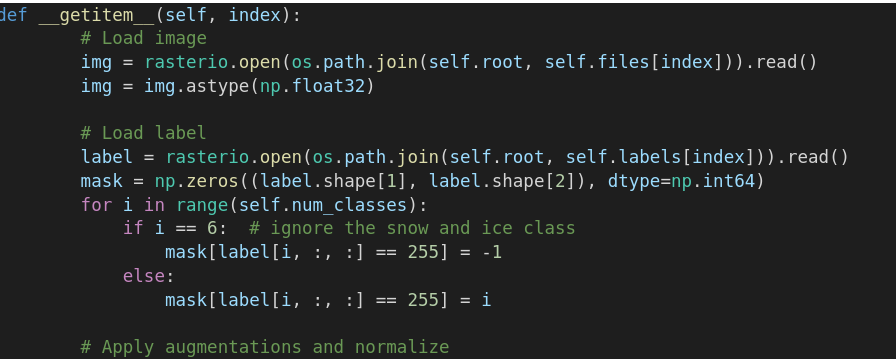

## Iniziamo

Questo è il mio progetto che ha come protagonista la Semantic Segmentation e la change detection.

##Che cosa vogliamo fare?
Si tratta di un problema di classificazione.Abbiamo a disposizione il dataset Sentinel2 con immagini satellitari , il nostro scopo sarà quello di classificare ogni pixel in base a 7 classi.

Importiamo le librerie e i moduli necessari.

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, ConcatDataset
from torchvision import datasets, transforms
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from google.colab import drive
from tqdm import tqdm
import time
!pip install albumentations
import albumentations as A
!pip install  segmentation_models_pytorch
import segmentation_models_pytorch as smp
import pandas as pd
from torch.utils.data import Dataset

!pip install rasterio
import rasterio
from rasterio.plot import show

torch.manual_seed(42) # Setting the seed
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False
## colleghiamo con google dirve
from google.colab import drive
drive.mount('/content/drive')



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=5c744d28124499886696126184d3a91b4fba4f0240f5b56963e9bf036d191563
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=357502b71b2b641d7aa119ee72fe8449b9e05f72c0c5186af3c3426dcf966e94
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [ ]:
##Osserviamo una specifica immagine
file= rasterio.open("/content/drive/MyDrive/Lab_IA/sentinel2/1330_3107_13/2018_02.tif").read()
print("L'immagine ha dimensioni...",file.shape)
print(file.dtype)


L'immagine ha dimensioni... (12, 1024, 1024)
int16


In [2]:
## TUTTE LE COSTANTI
EPOCHS= 200
ROOT= "/content/drive/MyDrive/Lab_IA"
CLASS_LABELS={ 0: "impervious serface",
               1: "agriculture",
               2: "forest & other vegetation",
               3: "wetlands",
               4: "soil",
               5: "water",
               6:"snow & ice"}
CHECKPOINT_DIR='/content/drive/MyDrive/Lab_IA/checkpoints'
NUM_WORKERS=4
NUM_CLASSES=7
MEAN=None
STD=None



Implementiamo la classe per il nostro dataset.

Come metriche utilizziamo

>IoU: The ratio between the intersection and the union of the predicted
segmentation and the ground truth.E'anche famosa come Jaccard Index,la usiamo per valutare l'accuratezza della sovrapposizione tra maschere predette e maschere di groud-truth


> mIoU: The mean of the IoU values across all the classes

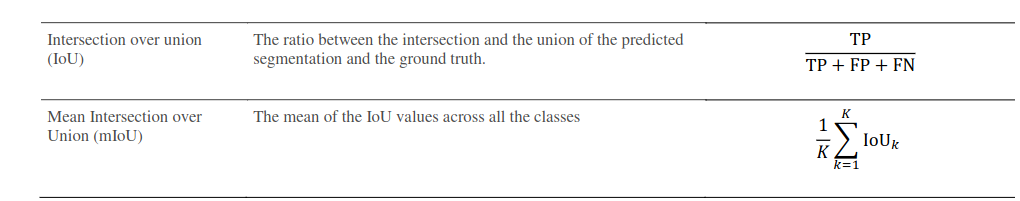







In [3]:

## Funzioni per data augmentation
def get_train_augmentations():
      '''
      '''
      transforms=[]
      transforms.extend([
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.5),
          A.RandomRotate90(p=1.0),
      ])

      return A.Compose(transforms)

def get_test_augmentations():
      transforms=[]

      '''
      '''

      return A.Compose(transforms)

o

In [4]:
class MyDynamicEarthNet(Dataset):
    def __init__(self, root, mode, mean=np.zeros((12,)),std=np.zeros((12,)),num_classi=7 ):
        """
        Args:
            root: the root of the folder which contains planet imagery and labels
            mode: train/val/test -- selects the splits

            reference_date: for positional encoding defaults:2018-01-01
            crop_size: crop size default:1024x1024
            num_classes: for DynamicEarthNet numclasses: 6

        """
        self.root = root
        self.mode = mode

        self.num_classi = num_classi
        self.mean=mean
        self.std=std
        self.normalize = None

        self.files,self.labels= self.get_file_labels(mode)



        if(mode=="train"):
          self.augmentations= get_train_augmentations()
          ##media e deviazione standard le calcolo sul training set
          self.calculate_mean_std()
        else:
          self.augmentations= get_test_augmentations()






    def get_file_labels(self,mode):

      with open(os.path.join(self.root,self.mode+".txt"),"r") as f:
        lista_file=[]
        for line in tqdm(f):
          line=line.rstrip().split(' ')
          file_path=line[0]
          label_path=line[1]
          nome_file=file_path.split("/")[2]
          nome_file=nome_file.split("-")[0]+"_"+nome_file.split("-")[1]+".tif"
          file_path=file_path.split("/")[0]+"/"+file_path.split("/")[1]+"/"+nome_file
          #print("File path:",file_path,"\n e label_path:",label_path,"\n")
          lista_file.append((file_path,label_path))
        self.files,self.labels=list(zip(*lista_file))

      #print("sto per calcolare la media e std")
      #self.mean,self.std= self.calculate_mean_std()
      print("\n\nLe liste self.files e self.labels sono pronte\n")
      return self.files, self.labels


    '''
    def set_files(self):
        self.file_list = os.path.join(self.root, "dynnet_training_splits", f"{self.mode}" + ".txt")
        print (self.file_list)
        file_list = [line.rstrip().split(' ') for line in tuple(open(self.file_list, "r"))]
        self.files, self.labels, self.year_months = list(zip(*file_list))

        if self.type == 'daily':
            self.all_days = list(range(len(self.files)))

            for i in range(len(self.files)):
                self.planet, self.day = [], []
                date_count = 0
                for _, _, infiles in os.walk(os.path.join(self.root, self.files[i][1:])):
                    for infile in sorted(infiles):
                        if infile.startswith(self.year_months[i]):
                            self.planet.append(os.path.join(self.files[i], infile))
                            self.day.append((datetime(int(str(infile.split('.')[0])[:4]), int(str(infile.split('.')[0][5:7])),
                                                  int(str(infile.split('.')[0])[8:])) - self.reference_date).days)
                            date_count += 1
                self.all_days[i] = list(zip(self.planet, self.day))
                self.all_days[i].insert(0, date_count)

        else:
            self.planet, self.day = [], []
            if self.type == 'weekly':
                self.dates = ['01', '05', '10', '15', '20', '25']
            elif self.type == 'single':
                self.dates = ['01']

            for i, year_month in enumerate(self.year_months):
                for date in self.dates:
                    curr_date = year_month + '-' + date
                    self.planet.append(os.path.join(self.files[i], curr_date + '.tif'))
                    self.day.append((datetime(int(str(curr_date)[:4]), int(str(curr_date[5:7])),
                                                  int(str(curr_date)[8:])) - self.reference_date).days)
            self.planet_day = list(zip(*[iter(self.planet)] * len(self.dates), *[iter(self.day)] * len(self.dates)))


    def load_data(self, index):
        cur_images, cur_dates = [], []
        if self.type == 'daily':
            for i in range(1, self.all_days[index][0]+1):
                img = rasterio.open(os.path.join(self.root, self.all_days[index][i][0][1:]))
                red = img.read(3)
                green = img.read(2)
                blue = img.read(1)
                nir = img.read(4)
                image = np.dstack((red, green, blue, nir))
                cur_images.append(np.expand_dims(np.asarray(image, dtype=np.float32), axis=0)) # np.array already\
                cur_dates.append(self.all_days[index][i][1])

            image_stack = np.concatenate(cur_images, axis=0)
            dates = torch.from_numpy(np.array(cur_dates, dtype=np.int32))
            label = rasterio.open(os.path.join(self.root, self.labels[index][1:]))
            label = label.read()
            mask = np.zeros((label.shape[1], label.shape[2]), dtype=np.int32)

            for i in range(self.num_classes + 1):
                if i == 6:
                    mask[label[i, :, :] == 255] = -1
                else:
                    mask[label[i, :, :] == 255] = i

            return (image_from torch.utils.data import Datasetstack, dates), mask

        else:
            for i in range(len(self.dates)):
                # read .tif
                img = rasterio.open(os.path.join(self.root, self.planet_day[index][i][1:]))
                red = img.read(3)
                green = img.read(2)
                blue = img.read(1)
                nir = img.read(4)
                image = np.dstack((red, green, blue, nir))
                cur_images.append(np.expand_dims(np.asarray(image, dtype=np.float32), axis=0))   # np.array already\
            image_stack = np.concatenate(cur_images, axis=0)
            dates = torch.from_numpy(np.array(self.planet_day[index][len(self.dates):], dtype=np.int32))
            label = rasterio.open(os.path.join(self.root, self.labels[index][1:]))
            label = label.read()
            mask = np.zeros((label.shape[1], label.shape[2]), dtype=np.int32)

            for i in range(self.num_classes+1):
                if i == 6:
                    mask[label[i, :, :] == 255] = -1
                else:
                    mask[label[i, :, :] == 255] = i

            return (image_stack, dates), mask
  '''

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        ##immagine cercata
        imm= rasterio.open(os.path.join(self.root,self.files[index])).read()

        ##il formato giusto è float32
        imm=imm.astype(np.float32)

        ##carico anche l'etichetta
        label= rasterio.open(os.path.join(self.root,self.labels[index])).read()
        ##maschera per la classe
        mask=np.zeros((label.shape[1],label.shape[2]),dtype=np.int64)     ## label.shape[1] la larghezza e label.shape [2] per altezza
        for i in tqdm(range(self.num_classi)):
          ## non considero la classe 6 corrispondente a snow and ice
          if i==6:
            mask[label[i,:,:]==255]=-1
          else:
            mask[label[i,:,:]==255]=i

        ## è il momento di normalizzare e fare data augmentation
        imm_trasp=imm.transpose(1,2,0)
        augm= self.augmentations(image=imm_trasp,mask=mask)
        ##transformo in tensore
        img= torch.from_numpy(augm["image"].transpose(2,0,1))
        img=img.to(device)

        #normalizzo
        img=self.normalize(img)


        return img, mask



    def calculate_mean_std(self):
      # Mean
      print("Sto calcolando la media")

      nontrovati=[]

      sum= np.zeros((12,))
      sum=sum.astype(np.float64)
      num_pixel=0
      i=0
      for im in tqdm(self.files):
        im_path= os.path.join(self.root,im)
        if os.path.exists(im_path)==False:
          nontrovati.append(im_path)
          #print("\nPath ",im_path,"  non trovato,lo salto :( ")
          continue
        src= rasterio.open(im_path)
        img=src.read()
        if(i==0):
          #print("\nimg ha shape: ",img.shape,"\n")
          i+=1
        sum += np.sum(img,axis=(1,2))
        num_pixel+=img.shape[1]* img.shape[2]

      mean=  sum/num_pixel


      ## Deviazione standard
      print("Ora calcolo la deviazione standard")
      sum= np.zeros((12,))
      sum=sum.astype(np.float64)

      for im in tqdm(self.files):

        im_path= os.path.join(self.root,im)
        if os.path.exists(im_path)==False:
          #print("\nPath ",im_path,"  non trovato,lo salto :( ")
          continue
        src= rasterio.open(im_path)
        img=src.read()
        sum += np.sum((img-mean.reshape(12,1,1))**2,axis=(1,2))

      std=  np.sqrt(sum/num_pixel)
      STD=std
      self.std=std
      MEAN=mean
      self.mean=mean
      print(f"Mean:{self.mean}")

      print(f"Std:{self.std}")
      self.normalize = transforms.Normalize(mean=self.mean, std=self.std)

      print("Path non trovati...\n",nontrovati)


##creazione training set
training_set= MyDynamicEarthNet(root=ROOT ,mode='train')


1056it [00:00, 4587.64it/s]




Le liste self.files e self.labels sono pronte

Sto calcolando la media


  0%|          | 1/1056 [00:01<29:07,  1.66s/it]


img ha shape:  (12, 1024, 1024) 



100%|██████████| 1056/1056 [11:36<00:00,  1.52it/s]


Ora calcolo la deviazione standard


100%|██████████| 1056/1056 [06:00<00:00,  2.93it/s]

Mean:[1172.19328983 1400.06327287 1446.52633482 2774.75166992 1809.95593384
 2473.51136111 2725.8684945  2884.20716899 2351.73818368 1751.09612993
 1086.05440252 3114.15244344]
Std:[1589.62818241 1510.50277198 1574.79573854 1415.32693599 1556.10662877
 1408.36338065 1412.76236733 1404.81120492 1380.26829348 1306.86991945
 1648.63427304 2026.37363878]
Path non trovati...
 ['/content/drive/MyDrive/Lab_IA/sentinel2/2459_4406_13/2018_02.tif', '/content/drive/MyDrive/Lab_IA/sentinel2/4169_3944_13/2019_07.tif', '/content/drive/MyDrive/Lab_IA/sentinel2/6381_3681_13/2019_08.tif', '/content/drive/MyDrive/Lab_IA/sentinel2/6475_3361_13/2019_11.tif', '/content/drive/MyDrive/Lab_IA/sentinel2/6688_3456_13/2019_01.tif', '/content/drive/MyDrive/Lab_IA/sentinel2/6810_3478_13/2019_02.tif']


In [ ]:
'''
## prova per vedere conversione array
print(training_set.std)
#std_tensor= torch.from_numpy(training_set.std)
std_tensor = torch.as_tensor(training_set.std,dtype=torch.float32)

print("Std tenosor:",std_tensor,end="\n")
'''

[1589.62818241 1510.50277198 1574.79573854 1415.32693599 1556.10662877
 1408.36338065 1412.76236733 1404.81120492 1380.26829348 1306.86991945
 1648.63427304 2026.37363878]
Std tenosor: tensor([1589.6282, 1510.5028, 1574.7958, 1415.3269, 1556.1067, 1408.3634,
        1412.7623, 1404.8112, 1380.2683, 1306.8699, 1648.6343, 2026.3737])


In [ ]:
##creazione training set
training_set= MyDynamicEarthNet(root=ROOT ,mode='train')


1080it [00:00, 192448.31it/s]



Le liste self.files e self.labels sono pronte



In [ ]:
#validation set
validation_set=MyDynamicEarthNet(root=ROOT,mode="val")

120it [00:01, 80.90it/s]



Le liste self.files e self.labels sono pronte



In [ ]:
# test set
test_set=MyDynamicEarthNet(root=ROOT,mode="test")

120it [00:00, 150.57it/s]



Le liste self.files e self.labels sono pronte



In [5]:
def color_map(N=7, normalized=False):

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)

    cmap[0] = np.array([96, 96, 96])  # impervious surface
    cmap[1] = np.array([204, 204, 0])  # agriculture
    cmap[2] = np.array([0, 204, 0])  # forest & other
    cmap[3] = np.array([0, 0, 153])  # wetland
    cmap[4] = np.array([153, 76, 0])  # soil
    cmap[5] = np.array([0, 128, 255])  # water

    #snow rgb in the paper 138, 178, 198
    cmap = cmap/255 if normalized else cmap
    return cmap

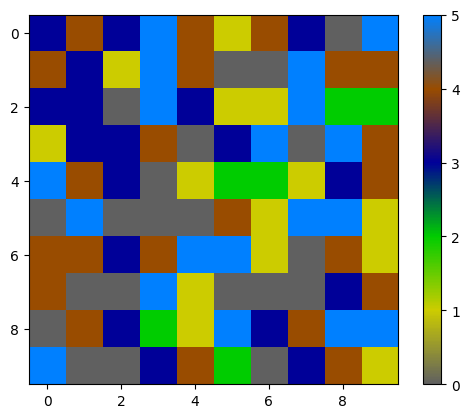

In [12]:

from matplotlib.colors import LinearSegmentedColormap

def create_custom_cmap():
    """
    Crea una mappa dei colori personalizzata (cmap) utilizzando i colori specificati.

    Ritorna:
    cmap -- la mappa dei colori personalizzata
    """
    cmap = np.zeros((6, 3), dtype=np.uint8)

    cmap[0] = np.array([96, 96, 96])  # impervious surface
    cmap[1] = np.array([204, 204, 0])  # agriculture
    cmap[2] = np.array([0, 204, 0])  # forest & other
    cmap[3] = np.array([0, 0, 153])  # wetland
    cmap[4] = np.array([153, 76, 0])  # soil
    cmap[5] = np.array([0, 128, 255])  # water

    # Normalizza i colori tra 0 e 1
    normalized_colors = cmap / 255.0

    # Crea una lista di punti per la mappa dei colori
    points = np.linspace(0, 1, len(normalized_colors))

    # Crea il dizionario dei segmenti di colore per la mappa dei colori
    color_segments = {'red': [], 'green': [], 'blue': []}
    for i, color in enumerate(normalized_colors):
        color_segments['red'].append((points[i], color[0], color[0]))
        color_segments['green'].append((points[i], color[1], color[1]))
        color_segments['blue'].append((points[i], color[2], color[2]))

    # Crea la mappa dei colori personalizzata
    cmap = LinearSegmentedColormap('custom_cmap', color_segments)

    return cmap

# Esempio di utilizzo
custom_cmap = create_custom_cmap()

# Esempio di applicazione della mappa dei colori a un grafico
data = np.random.randint(0, 6, size=(10, 10))  # Dati di esempio
plt.imshow(data, cmap=custom_cmap)
plt.colorbar()
plt.show()


100%|██████████| 7/7 [00:00<00:00, 716.92it/s]


Analizziamo l'immagine num  66


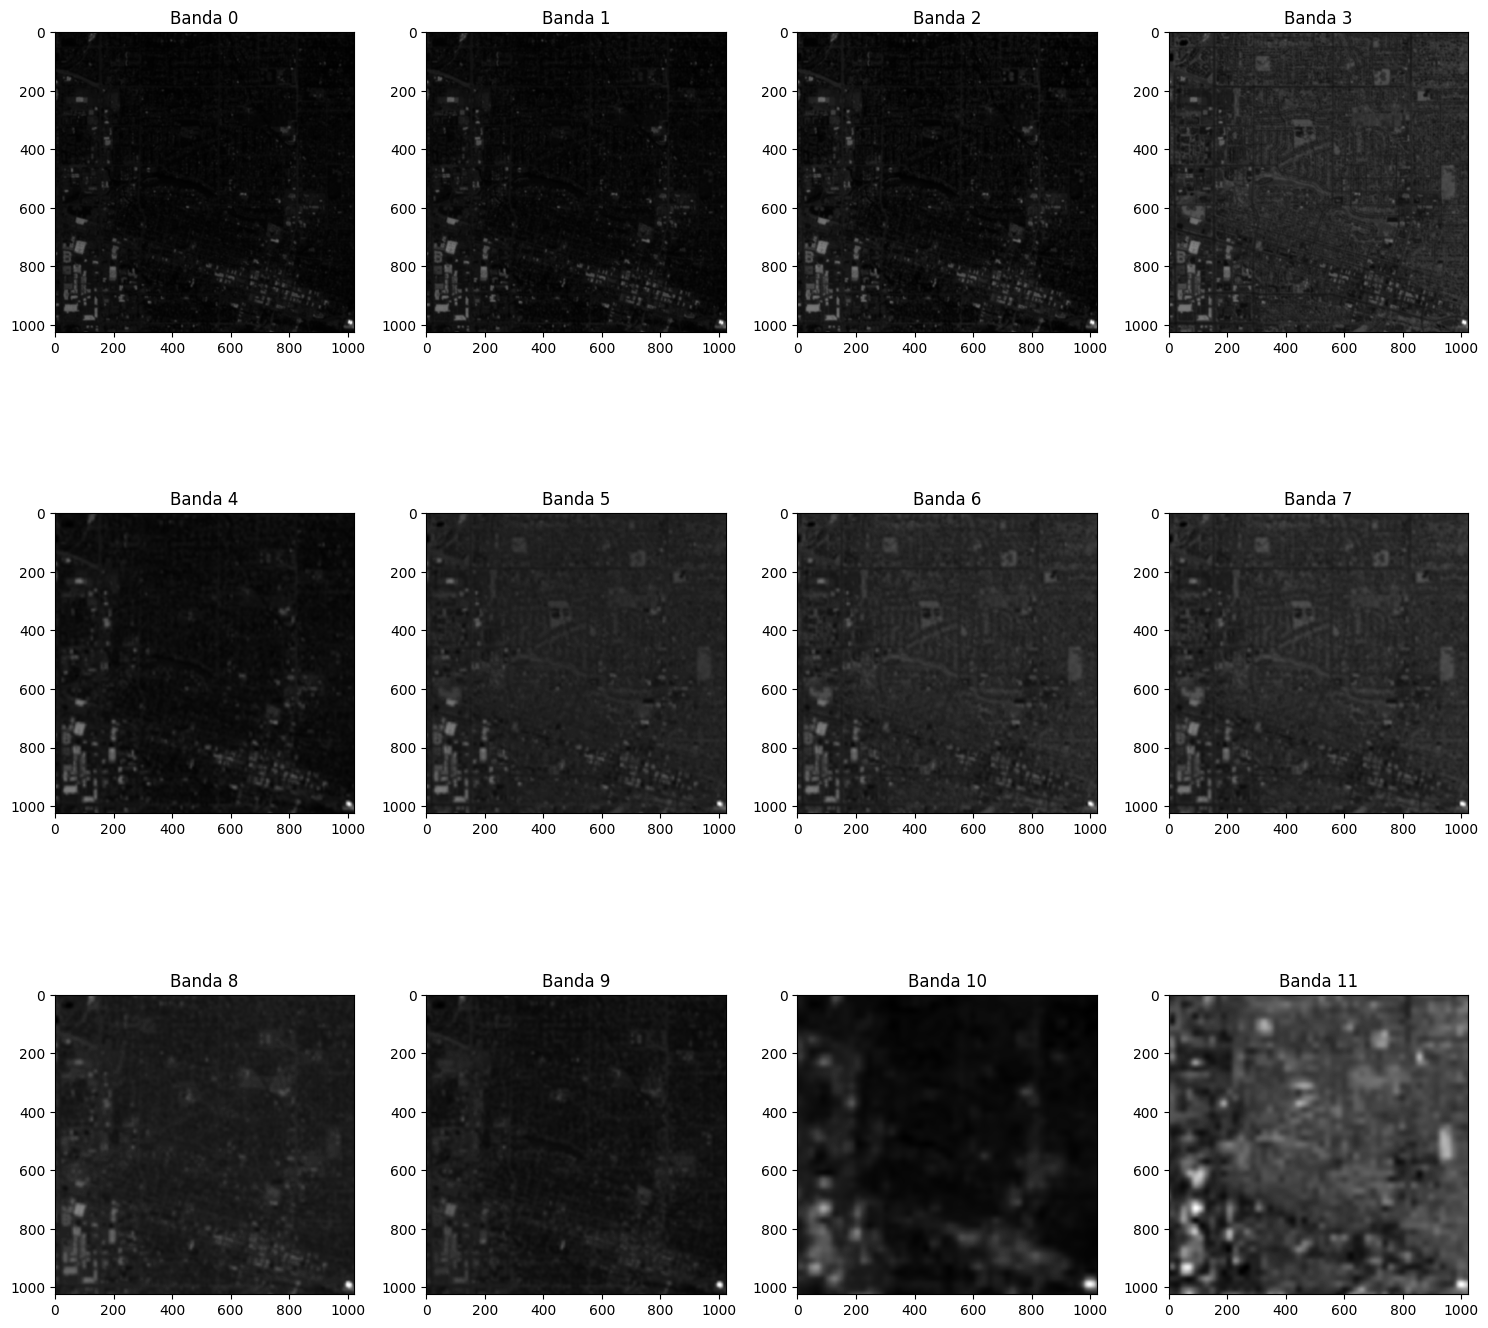

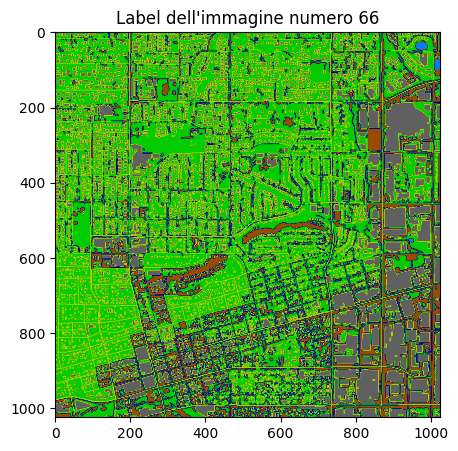

In [15]:
## proviamo a visualizzare tutti i canali di una specifica immagine .tif
index_pic=66
image,mask=training_set.__getitem__(index_pic)
image=image.to(device)
colors=color_map(normalized=True)

# show the enhanced image
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 15))
print("Analizziamo l'immagine num ",index_pic)
image=image.permute(1,2,0)
a=0
b=0
for i in range(image.shape[2]):
  axs[a,b].imshow(image[:,:,i].cpu(),cmap="gray")
  axs[a,b].set_title(f"Banda {i}")
  b+=1
  if i!=0 and b==4:
    a+=1
    b=0
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
axs.imshow(mask,cmap=custom_cmap)
axs.set_title(f"Label dell'immagine numero {index_pic}")
plt.show()

In [ ]:
# Crea il DataLoader utilizzando il dataset
train_loader= DataLoader(training_set, batch_size=1, shuffle=True, num_workers=4,pin_memory=True)
val_loader= DataLoader(validation_set,batch_size=1, shuffle=True, num_workers=4,pin_memory=True)
#test_loader=DataLoader(test_set,batch_size=1, shuffle=True, num_workers=4,pin_memory=True)

#UNet
Implementiamo adesso la rete UNet che è una fully-convolutional-network

First path is the contraction path (also called as the encoder) which is used to capture the context in the image. The encoder is just a traditional stack of convolutional and max pooling layers. The second path is the symmetric expanding path (also called as the decoder) which is used to enable precise localization using transposed convolutions. Thus it is an end-to-end fully convolutional network (FCN), i.e. it only contains Convolutional layers and does not contain any Dense layer because of which it can accept image of any size.

In [ ]:
n_channels=12
class UNet(nn.Module):
  def __init__(self):
    super(UNet,self).__init__()
    self.model = smp.Unet(in_channels=n_channels,classes=1,)
    self.model.encoder.conv1=nn.Conv2d(n_channels,out_channels=32,kernel_size=(3,3),stride=(1,1),padding=(1,1),bias=False)
    self.model.segmentation_head[0]=nn.Conv2d(16,6,kernel_size=(1,1),stride=(1,1))

  def forward(self,x):
    return self.model(x)

##testing my unet
model=UNet().to(device)
print(model)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 104MB/s]


UNet(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm

In [ ]:
import torch
import torchvision.models.segmentation as models
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

import segmentation_models_pytorch as smp

# Carica il modello U-Net predefinito
model = smp.Unet()

# Stampa l'architettura del modello
print(model)


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
#The optimizer (SGD) and the criterian for crossentropy
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)# insert optimizer instantiation
criterion =  torch.nn.CrossEntropyLoss().to(device)# insert loss instantiation
print(model)

In [ ]:
from argparse import Namespace
class WrapperUNet:
  def __init__(self,net,iter_per_epoch):
    self.net=net
    self.best_acc = 0.0
    self.iter_per_epochs=iter_per_epoch
    self.num_classes= NUM_CLASSES


  def train_epoch(self,epoch,data_loader):
    pass

  def evaluate_model(self,epoch,data_loader):
    """ Le metriche che utilizzo sono IoU e mIoU
    """
    self.net.eval()
    pred = self.net.forward(image)
    epoch_val_loss = []
    total_correct, total_label = 0, 0
    total_inter, total_union = 0, 0
    pixAcc=0.0
    with torch.no_grad():
            for i, data in enumerate(data_loader):
                (image,dates), mask = self.recursive_todevice(data)
                mask = mask.long()
                pred = self.net.forward(image, batch_positions=dates)
                val_loss = self.semantic_seg_loss(pred, mask)
                epoch_val_loss.append(val_loss.item())
                correct, labeled, inter, union = get_metrics(pred, mask, NUM_CLASSES, self.config['DATA']['IGNORE_INDEX'])
                total_inter, total_union = total_inter + inter, total_union + union
                total_correct, total_label = total_correct + correct, total_label + labeled


                pixAcc = 1.0 * total_correct / (np.spacing(1) + total_label)



    metrics= Namespace(pixAcc=pixAcc, mIoU=mIoU,IoU=IoU)#, c=seg_metrics["Class_IoU"])
    return metrics


  def optim_step_(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

  def checkp_saving(self,epoch,out_dir,last_ckpt=False,best_acc=None,is_best=False):
    ckpt = {'last_epoch': epoch, 'best_acc': best_acc, 'model_dict': self.net.state_dict(),
                'optimizer_dict': self.optimizer.state_dict(),
                'lr_scheduler_dict': self.lr_scheduler.state_dict() if self.lr_scheduler else None}
    if last_ckpt:
       ckpt_name = 'last_ckpt.pth'
    elif is_best:
       ckpt_name = 'best_ckpt.pth'
    else:
       ckpt_name = 'ckpt_ep{}.pth'.format(epoch + 1)
    ckpt_path = os.path.join(out_dir, ckpt_name)
    torch.save(ckpt, ckpt_path)


  def load_checkpoint(self,C):
    pass

  def print_net_(self):
        for k, v in self.net.state_dict().items():
            print(k, v.size())


In [ ]:
## funzioni per metriche

def get_intersection_union(pred,label,n_classi=NUM_CLASSES):
    #pred è un tensore(altezza,profondità)
    #convertiamo in np.array
    ## aggiungiamo +1 per ignorare i valori -1 corrispondenti alla classe snow and ice
    pred=np.asarray(pred)+1
    label= np.asarray(label)+1

    #elimino tutti gli elementi in pred corrispondenti alla classe 0
    pred= pred * (label>0)
    # calcolo intersezione
    intersezione= (pred==label)*pred
    inters_area= np.histogram(intersezione,bins=n_classi,range=(1,n_classi))
    pred_area= np.histogram(pred,bins=n_classi,range=(1,n_classi))
    label_area= np.histogram(label,bins=n_classi,range=(2,n_classi))

    ## per il calcolo dell'area di unione sommo le aree di pred e label e sottraggo l'intersezione
    unione_area= pred_area+label_area-inters_area
    return inters_area,unione_area

def get_IoU(intersezione,unione):
  iou= intersezione/unione
  return iou

def get_mIoU(iou_values):
  mean_iou= np.mean(iou_values)
  return mean_iou


def accuracy_batch(output, target):
    _, predict = torch.max(output, 1)

    predict = predict.int() + 1
    target = target.int() + 1

    pixel_labeled = (target > 0).sum()
    pixel_correct = ((predict == target)*(target > 0)).sum()
    assert pixel_correct <= pixel_labeled, "Correct area should be smaller than Labeled"
    return pixel_correct.cpu().numpy(), pixel_labeled.cpu().numpy()

def pixel_accuracy(output, target):
    output = np.asarray(output)
    target = np.asarray(target)
    pixel_labeled = np.sum(target > 0)
    pixel_correct = np.sum((output == target) * (target > 0))
    return pixel_correct, pixel_labeled

def get_metrics(output, target, num_classes=NUM_CLASSES, ignore_index):
    target = target.clone()
    target[target == ignore_index] = -1
    correct, labeled = accuracy_batch(output.data, target)
    inters,union= get_intersection_union(pred,label)
    iou_array= get_IoU(inters,union)
    mIoU= get_mIoU(iou_array)
    return [np.round(correct, 5), np.round(labeled, 5), np.round(inters, 5), np.round(union, 5)]

In [ ]:
iter_per_epoch = len(train_loader)
wrapper = WrapperUNet(model, iter_per_epoch)
best_acc = wrapper.best_acc

print("Starting epochs now...")
for epoch in tqdm(range(EPOCHS)):
  start_time=time.time()
  print(f"Num epoch {epoch}")
  wrapper.train_epoch(epoch,train_loader)
  wrapper.checkp_saving(epoch,CHECKPOINT_DIR,best_acc=best_acc,last_ckpt=True)

  ## evaluation su validation set
  metrics=wrapper.evaluate_model(epoch,val_loader)
  print(f"Evaluation epoch {epoch},IoU:{metrics.IoU} meanIoU:{metrics.mIoU}")


  ## save best model

  mean_iou = metrics.mIoU

  if mean_iou > best_acc:
        best_acc = mean_iou
        wrapper.checkpt_saving(epoch, CHECKPOINT_DIR, best_acc=best_acc, is_best=True)
        print(f'>>Save best model: epoch={epoch} best_iou:{mean_iou}')

  ## statistics
  end_time=time.time()
  print(f"Time epoch {epoch}: {end_time-start_time}")


Starting epochs now...


100%|██████████| 200/200 [00:00<00:00, 1360.88it/s]

Num epoch 0
Evaluation epoch 0,IoU:None meanIoU:None
Time epoch 0: 8.273124694824219e-05
Num epoch 1
Evaluation epoch 1,IoU:None meanIoU:None
Time epoch 1: 3.0040740966796875e-05
Num epoch 2
Evaluation epoch 2,IoU:None meanIoU:None
Time epoch 2: 2.9087066650390625e-05
Num epoch 3
Evaluation epoch 3,IoU:None meanIoU:None
Time epoch 3: 2.7418136596679688e-05
Num epoch 4
Evaluation epoch 4,IoU:None meanIoU:None
Time epoch 4: 2.6702880859375e-05
Num epoch 5
Evaluation epoch 5,IoU:None meanIoU:None
Time epoch 5: 2.5033950805664062e-05
Num epoch 6
Evaluation epoch 6,IoU:None meanIoU:None
Time epoch 6: 2.7418136596679688e-05
Num epoch 7
Evaluation epoch 7,IoU:None meanIoU:None
Time epoch 7: 2.8133392333984375e-05
Num epoch 8
Evaluation epoch 8,IoU:None meanIoU:None
Time epoch 8: 2.765655517578125e-05
Num epoch 9
Evaluation epoch 9,IoU:None meanIoU:None
Time epoch 9: 2.7418136596679688e-05
Num epoch 10
Evaluation epoch 10,IoU:None meanIoU:None
Time epoch 10: 2.8371810913085938e-05
Num epoch 11